# Sistemas de Recomendación

In [10]:
# Importaciones necesarias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency
import joblib

## 1. Cargar del conjunto de datos

In [3]:
# Cargar el dataset
url = "https://raw.githubusercontent.com/4GeeksAcademy/predicting-your-future-with-data/main/adult-census-income.csv"
df = pd.read_csv(url)
df

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


## 2. Preprocesamiento de datos

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [5]:
df.duplicated().sum() # Comprobar la presencia de filas duplicadas

24

In [6]:
df.drop_duplicates(inplace=True) # Eliminar filas duplicadas
df.shape

(32537, 15)

In [7]:
df.isnull().sum() # Valores nulos 

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [8]:
df.nunique() # Valores unicos por columna

age                  73
workclass             9
fnlwgt            21648
education            16
education.num        16
marital.status        7
occupation           15
relationship          6
race                  5
sex                   2
capital.gain        119
capital.loss         92
hours.per.week       94
native.country       42
income                2
dtype: int64

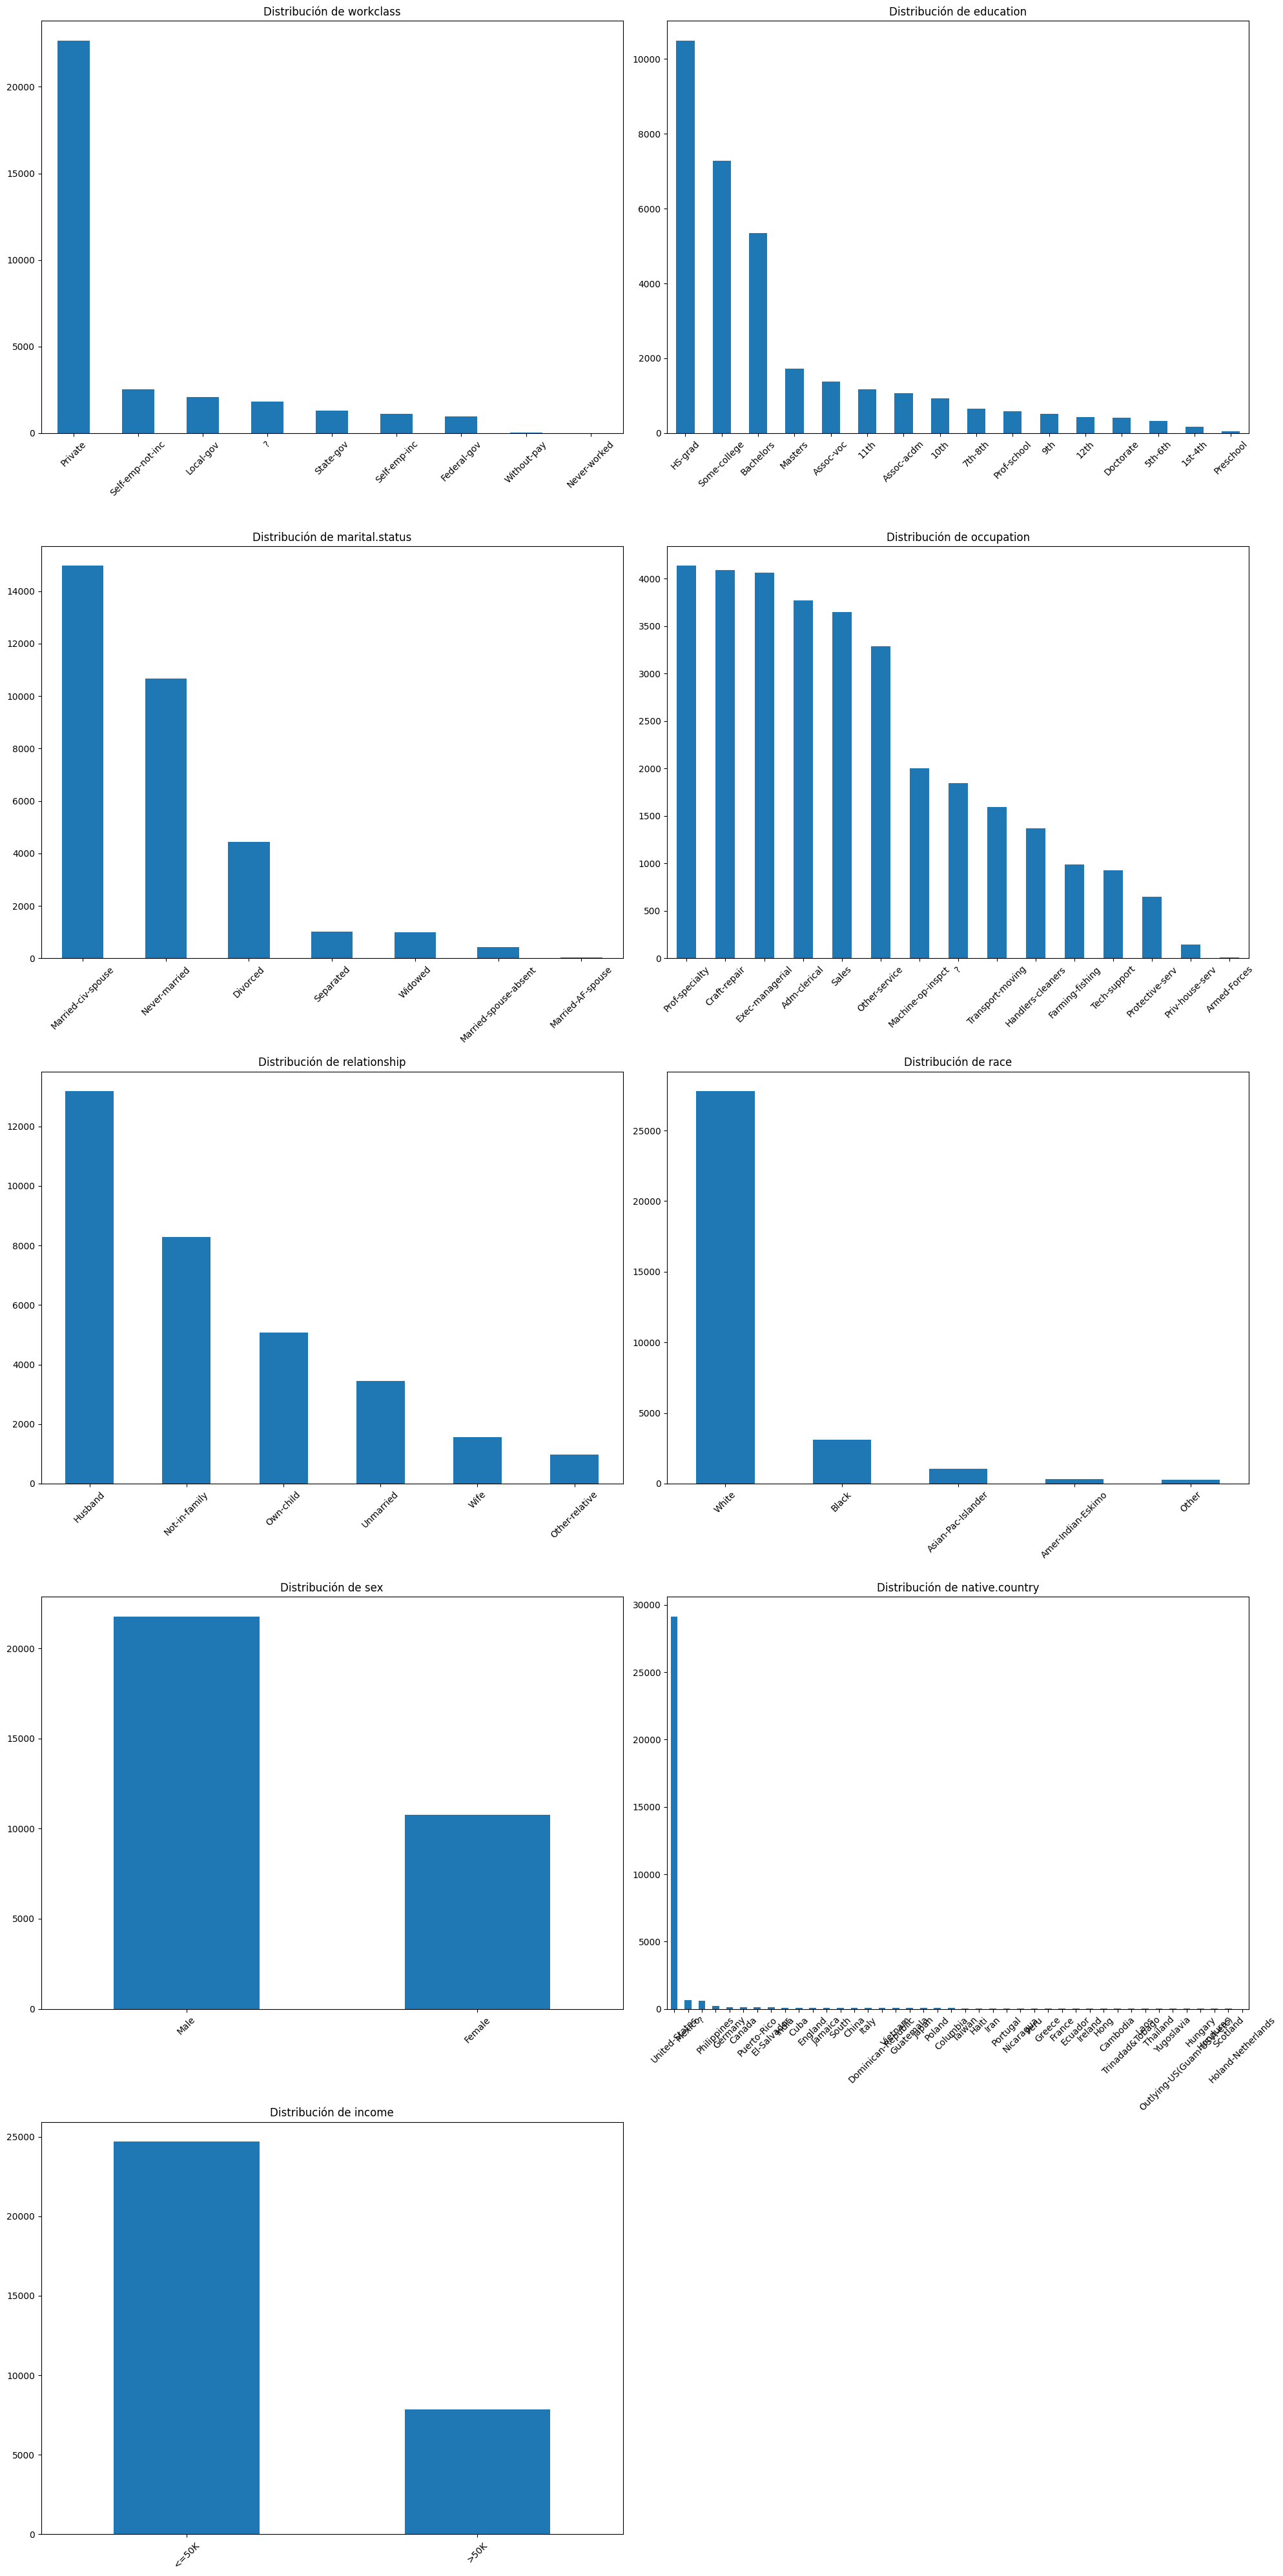

In [12]:
# Seleccionamos columnas categóricas
categorical_cols = df.select_dtypes(include='object').columns

# Configuramos número de filas y columnas para subplots
n_cols = 2
n_rows = 5

# Creamos la figura
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10 * n_cols, 8 * n_rows))
axes = axes.flatten()

# Generamos cada gráfica en su subplot
for i, col in enumerate(categorical_cols):
    df[col].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Distribución de {col}')
    axes[i].tick_params(axis='x', rotation=45)

# Eliminamos ejes vacíos si sobran
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [13]:
(df == '?').sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     582
income               0
dtype: int64

In [14]:
df.replace("?", pd.NA, inplace=True) # Reemplazar "?" por NaN
df.isnull().sum() # Valores nulos

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     582
income               0
dtype: int64

In [15]:
# Rellenar con la moda los valores nulos
df["workclass"] = df["workclass"].fillna(df["workclass"].mode()[0])
df["occupation"] = df["occupation"].fillna(df["occupation"].mode()[0])
df["native.country"] = df["native.country"].fillna(df["native.country"].mode()[0])
df.isnull().sum() # Valores nulos

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [16]:
df.describe().T # Estadistica descrptiva para las columnas numericas

,count,mean,std,min,25%,50%,75%,max
age,32537.0,38.585549,13.637984,17.0,28.0,37.0,48.0,90.0
fnlwgt,32537.0,189780.848511,105556.471009,12285.0,117827.0,178356.0,236993.0,1484705.0
education.num,32537.0,10.081815,2.571633,1.0,9.0,10.0,12.0,16.0
capital.gain,32537.0,1078.443741,7387.957424,0.0,0.0,0.0,0.0,99999.0
capital.loss,32537.0,87.368227,403.101833,0.0,0.0,0.0,0.0,4356.0
hours.per.week,32537.0,40.440329,12.346889,1.0,40.0,40.0,45.0,99.0


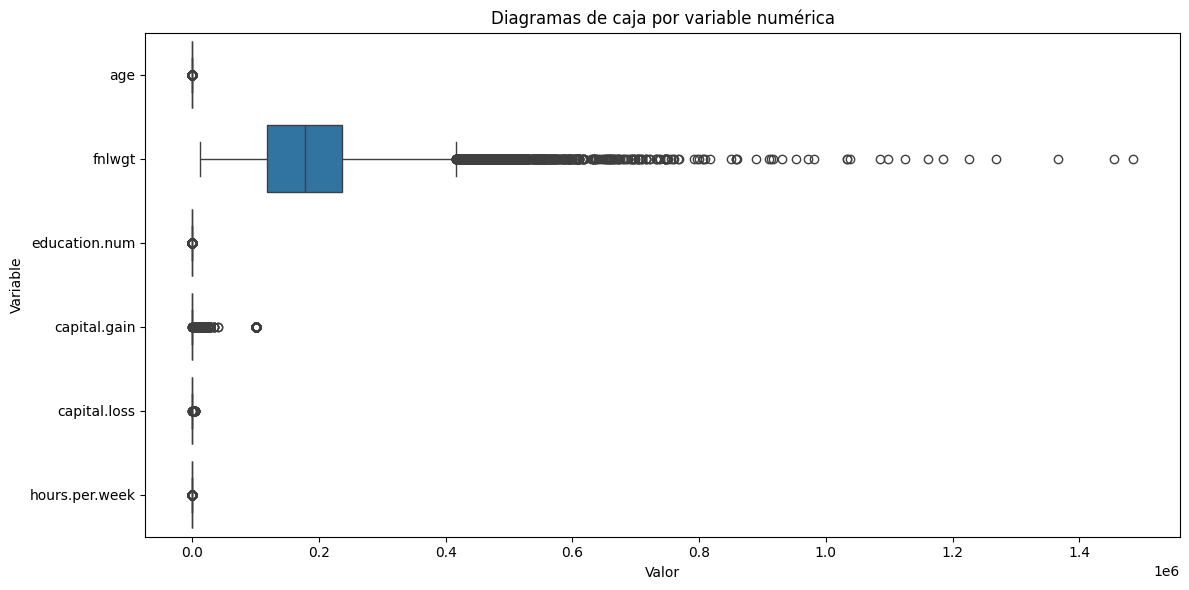

In [17]:
# Variables numéricas 
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Convertir a formato largo (tidy) es decir de un dataframe a solo dos columnas
df_long = df[num_cols].melt(var_name='variable', value_name='valor')

# Boxplot horizontal con seaborn
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_long, y='variable', x='valor', orient='h')
plt.title('Diagramas de caja por variable numérica')
plt.xlabel('Valor')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()

## 3. Define el problema de recomendación

## 4. Construye el sistema de recomendación

## 5. Pruebas con casos simulados